<a href="https://colab.research.google.com/github/ochekroun/labs/blob/master/IFAGE_Cours_5_L'environnement_DeliveryDrones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Préparation
---

Ce notebook ne nécessite pas de GPU.

In [ ]:
import sys

if 'google.colab' in sys.modules:
    # Clone le projet GitHub
    !git clone https://github.com/MasterScrat/droneRL-workshop.git --single-branch

    # Installe les packages via pip
    !pip install -r "droneRL-workshop/colab-requirements.txt"

    # Redémarre le Runtime pour utiliser les packages mis à jours
    import os
    os.kill(os.getpid(), 9)

    # Le Runtime va redémarrer après cette étape - c'est normal !

In [ ]:
%cd droneRL-workshop

/content/droneRL-workshop


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from PIL import Image
from IPython.lib.pretty import pretty

L'environnement DeliveryDrones
---

Après avoir créer l'environnement, appelez `reset()` pour l'initialiser.

In [ ]:
from env.env import DeliveryDrones

# Création de l'environnement
env = DeliveryDrones()

# Appelle de reset pour obtenir l'observation initiale
observation = env.reset()

# Rendu de l'environnement en mode texte
print(env.render(mode='ansi'))

+---+---+---+---+---+---+---+---+
|   |   |[ ]| x | # |   | x |[ ]|
+---+---+---+---+---+---+---+---+
|   |   |   |[ ]|   |   | @ |[ ]|
+---+---+---+---+---+---+---+---+
| # |   |   |   | @ |[ ]| @ | @ |
+---+---+---+---+---+---+---+---+
|   | x |   |   |   | x | x | # |
+---+---+---+---+---+---+---+---+
|   | # |[ ]| 2 |   | x |   |   |
+---+---+---+---+---+---+---+---+
|   |   |   | # | # |   | # |   |
+---+---+---+---+---+---+---+---+
|   |   |   |   | @ | x | # | x |
+---+---+---+---+---+---+---+---+
| 1 |   |   |0@ |   | x |   | # |
+---+---+---+---+---+---+---+---+


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


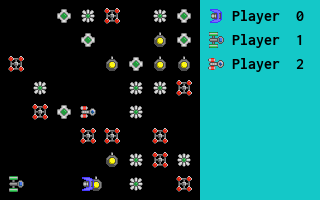

In [ ]:
# Rendu en mode RGB
Image.fromarray(env.render(mode='rgb_array'))

Les "observations" retournées par DeliveryDrones
---

Par défaut, cet environnement retourne deux tableaux qui pour `air` (le ciel) et `ground` (le sol).

In [ ]:
# Les observations sont retournées après un appel à env.reset() ou env.step()
print(observation)

{'ground': <env.env.Grid object at 0x7fcd30c63a60>, 'air': <env.env.Grid object at 0x7fcd30c61600>}


In [ ]:
observation['air'].grid

array([[None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None],
       [None, None, None, D2, None, None, None, None],
       [None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None],
       [D1, None, None, D0, None, None, None, None]], dtype=object)

On utilise des "observations wrappers" (des "enveloppes d'observations") pour obtenir des observations plus facilement utilisables par nos agents RL.


{1: 5, 2: 3, 0: 2}


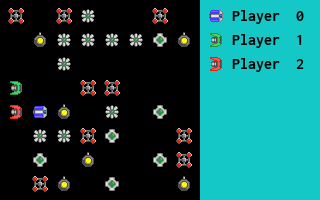

In [ ]:
from env.wrappers import CompassQTable, CompassChargeQTable, LidarCompassQTable, LidarCompassChargeQTable

env = DeliveryDrones()

# Crée un "observation wrapper"
# CompassQTable indique la prochaine direction que devrait prendre le drone
env = CompassQTable(env)

# D'autres observation wrappers sont disponibles :
#env = CompassChargeQTable(env)
#env = LidarCompassQTable(env)
#env = LidarCompassChargeQTable(env)

observation = env.reset()
print(pretty(observation))
Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
# On utilise `env.format_state` pour montrer l'observation de façon plus lisible
{drone: env.format_state(observation) for drone, observation in observation.items()}

{1: '↗', 2: '↘', 0: '↓'}

In [ ]:
from env.env import Action

Action??

Rewards: {0: 0, 1: 0, 2: 0}


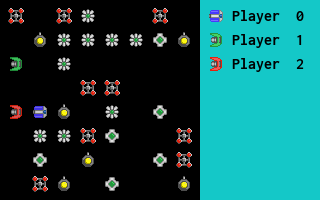

In [ ]:
observation, reward, done, info = env.step({
    0: Action.STAY, 1: Action.UP, 2: Action.STAY
  })

print('Rewards: {}'.format(reward))
Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
{drone: env.format_state(observation) for drone, observation in observation.items()}

{1: '→', 2: '↘', 0: '↓'}

L'observation wrapper `WindowedGridView`
---

`WindowedGridView` est un observation wrapper spécial qui nous montre une "fenêtre" autour de chaque agent.


Voilà sa documentation :
```
Observation wrapper: (N, N, 6) numerical arrays with location of
(0) drones         marked with                   1 / 0 otherwise
(1) packets        marked with                   1 / 0 otherwise
(2) dropzones      marked with                   1 / 0 otherwise
(3) stations       marked with                   1 / 0 otherwise
(4) drones charge  marked with   charge level 0..1 / 0 otherwise
(5) obstacles      marked with                   1 / 0 otherwise
Where N is the size of the window, i the number of drones
```

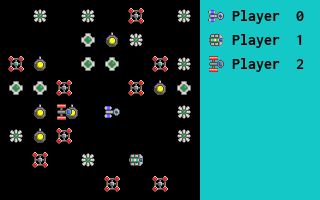

In [ ]:
from env.wrappers import WindowedGridView

env = WindowedGridView(DeliveryDrones(), radius=2)
states = env.reset()
Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
{drone: env.format_state(state) for drone, state in states.items()}

{2: 'Numpy array (5, 5, 6)',
 0: 'Numpy array (5, 5, 6)',
 1: 'Numpy array (5, 5, 6)'}

In [ ]:
states[0][:, :, 5] # Obstacles from the perspective of drone 0

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Création et interactions d'agents
---


In [ ]:
from agents.random import RandomAgent

# Creation de l'environnement
env = WindowedGridView(DeliveryDrones(), radius=3)
states = env.reset()

# On crée des agents aléatoires
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents

{0: <agents.random.RandomAgent at 0x7fcce7538ac0>,
 1: <agents.random.RandomAgent at 0x7fcce753a050>,
 2: <agents.random.RandomAgent at 0x7fcce7539e40>}

In [ ]:
# Les agents aléatoires choisissent des actions au hasard
RandomAgent??

In [ ]:
from helpers.rl_helpers import test_agents

# On laisse agir les agents pendant 1000 steps
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)

# Regardons leurs récompenses...
for drone_index, rewards in rewards_log.items():
    print('Drone {} rewards: {} ..'.format(drone_index, rewards[:10]))

/usr/local/lib/python3.10/dist-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 1907.95it/s]

Drone 0 rewards: [0, -1, 0, 0, 0, -0.1, 0, 0, -1, -0.1] ..
Drone 1 rewards: [-1, 0, 0, 0, -1, 0, 0, 0, 0, 0] ..
Drone 2 rewards: [-1, 0, -1, 0, 0, 0, -0.1, 0, -0.1, 0] ..


On peut visualiser ces récompenses grâce à la fonction `plot_cumulative_rewards` :

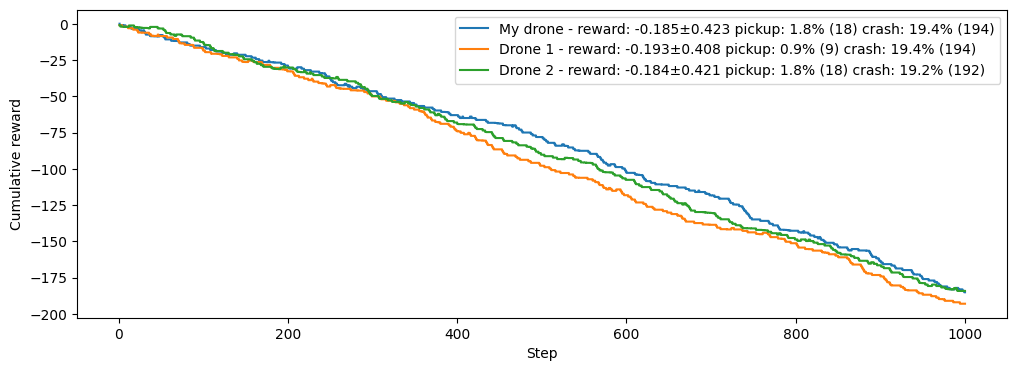

In [ ]:
from helpers.rl_helpers import plot_cumulative_rewards

plot_cumulative_rewards(
    rewards_log,
    events={'pickup': [1], 'crash': [-1]}, # Optional, default: pickup/crash ±1
    drones_labels={0: 'My drone'}, # Optional, default: drone index
)

Visualisons un "run"
---

In [ ]:
from helpers.rl_helpers import render_video, ColabVideo

path = os.path.join('output', 'videos', 'intro-run.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=None)

  from scipy.ndimage.filters import sobel

t:   0%|                                                | 3/2880 [00:00<01:43, 27.91it/s, now=None]

Moviepy - Building video output/videos/intro-run.mp4.
Moviepy - Writing video output/videos/intro-run.mp4



Moviepy - Done !
Moviepy - video ready output/videos/intro-run.mp4


In [ ]:
ColabVideo(path)

  and should_run_async(code)

